In [1]:
%matplotlib inline

#You need the following modues, if you don't have them, use pip install <module-name>
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Implicit Grant Flow
#Enter your OAuth token in place
#supposed to expire in 2021-03-27 - 12:40 PM - [GMT + 5:30 time zone]

access_token = "OAuth Token"

start_date = "2021-03-18"
end_date = "2021-03-30"


<h2>HR analysis</h2>

In [31]:
import datetime

#Update your start and end dates here in yyyy-mm-dd format 
start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.datetime.strptime(end_date, "%Y-%m-%d")

date_array = (start + datetime.timedelta(days=x) for x in range(0, (end-start).days))

day_list = []
for date_object in date_array:
    day_list.append(date_object.strftime("%Y-%m-%d"))
    
print("day range : ",day_list)

day range :  ['2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29']


In [32]:
df_all = pd.DataFrame()

In [33]:


header = {'Authorization': 'Bearer {}'.format(access_token)}

for single_day in day_list:
    response = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+ single_day +"/1d/1min/time/00:00/23:59.json", headers=header).json()
    df = pd.DataFrame(response['activities-heart-intraday']['dataset'])
    date = pd.Timestamp(single_day).strftime('%Y-%m-%d')
    df = df.set_index(pd.to_datetime(date + ' ' + df['time'].astype(str)))
    #print(df)
    df_all = df_all.append(df, sort=True)
    
del df_all['time']

In [34]:
#Put the interval you want to take the average of the imported data from fitbit with 2-5 sec interval. Default 10 minute
summary_df = (df_all['value'].resample('10Min').mean())

<AxesSubplot:xlabel='time'>

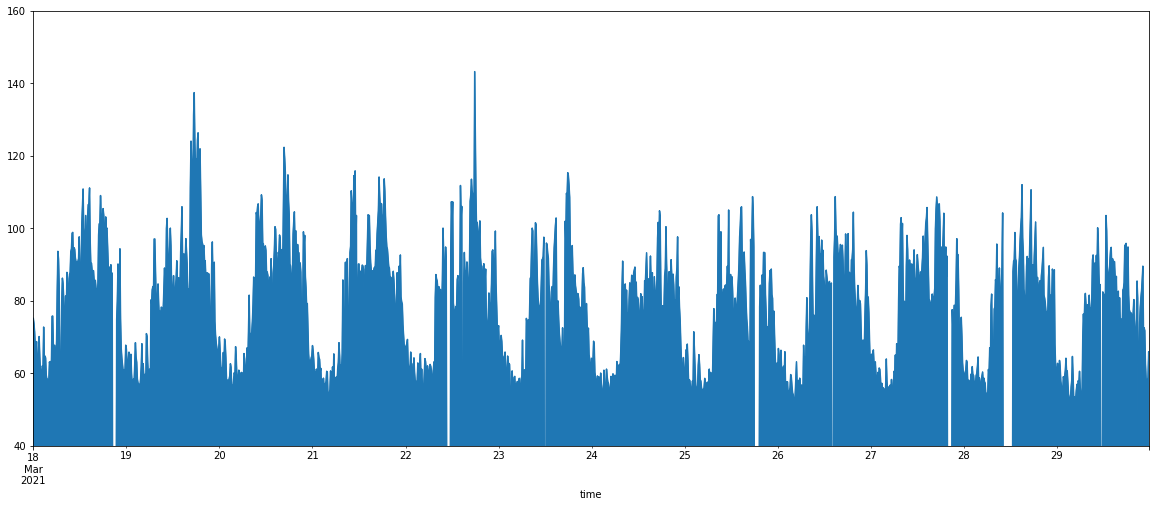

In [35]:
plt.rcParams["figure.figsize"]=20,8

# Heart rate data summary [10min avg] from start date[2021-03-18] to end date[2021-03-21] 
#if you are using matplotlib directly in python ( py file ) then use plt.plot(summary_df,kind='area')
summary_df.plot.area(ylim=(40,160))

<h2>Sleep analysis</h2>

In [16]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1.2/user/-/sleep/date/"+start_date+"/"+end_date+".json", headers=header).json()

In [43]:
combined_list = []
for i in range(len(response['sleep'])):
    result = response['sleep'][i]['levels']['summary']
    try:
        nice_dict = {'day':response['sleep'][i]['dateOfSleep'], 'deep_minutes':response['sleep'][i]['levels']['summary']['deep']['minutes'], 'light_minutes':response['sleep'][i]['levels']['summary']['light']['minutes'], 'rem_minutes':response['sleep'][i]['levels']['summary']['rem']['minutes'], 'wake_minutes':response['sleep'][i]['levels']['summary']['wake']['minutes']}
        combined_list.append(nice_dict)
    except:
        pass

In [44]:
sleep_df = pd.DataFrame(combined_list)

<AxesSubplot:xlabel='day'>

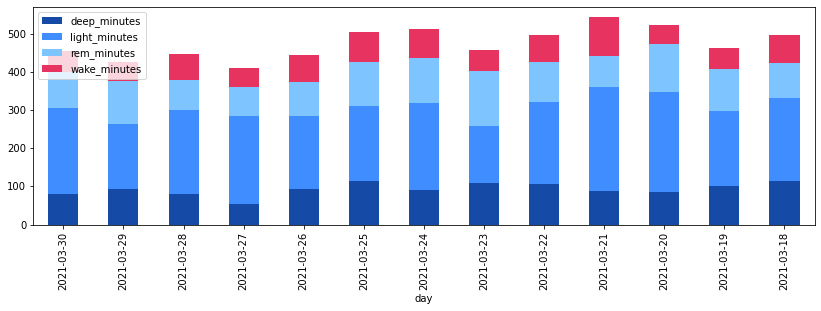

In [45]:
#Plotting data
plt.rcParams["figure.figsize"]=14,4
sleep_df.set_index('day').plot(kind='bar', stacked=True, color=['#154BA6', '#3F8DFF', '#7EC4FF', '#E73360'])

<h2>Resting heart rate</h2>

In [90]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+start_date+"/"+end_date+".json", headers=header).json()

In [91]:
all_resting_HR_list = []
for i in response['activities-heart']:
    resting_dict = { 'dateTime':i['dateTime'], "resting_HR":i['value']['restingHeartRate']}
    all_resting_HR_list.append(resting_dict)
    
resting_HR_df = pd.DataFrame(all_resting_HR_list)
resting_HR_df.dateTime = resting_HR_df.dateTime.apply(pd.Timestamp)
resting_HR_df.set_index("dateTime", inplace = True)

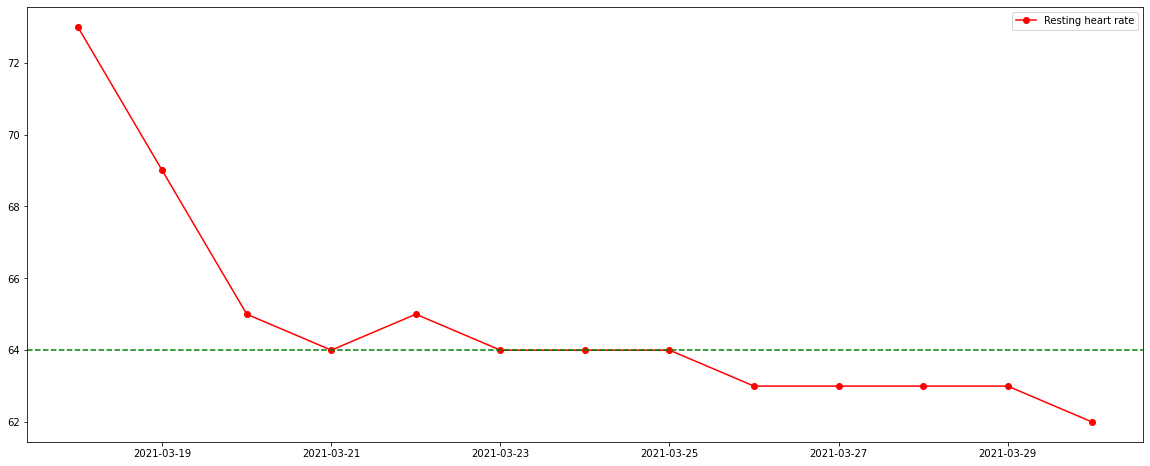

In [107]:
plt.rcParams["figure.figsize"]=20,8
#plt.ylim((60,75))
#plt.grid()
plt.plot(resting_HR_df,linestyle='-', marker='o', color='r', label = "Resting heart rate")
plt.legend()
plt.axhline(y = resting_HR_df.resting_HR.median(), color = 'g', linestyle = 'dashed')

In [97]:
start = pd.Timestamp(resting_HR_df.index[0])
end = pd.Timestamp(resting_HR_df.index[-1])
t = np.linspace(start.value, end.value, len(resting_HR_df.index))
x_ = pd.to_datetime(t)
y_ = resting_HR_df.resting_HR.to_list()

In [98]:
from scipy.interpolate import make_interp_spline

X_Y_Spline = make_interp_spline(x_,y_)

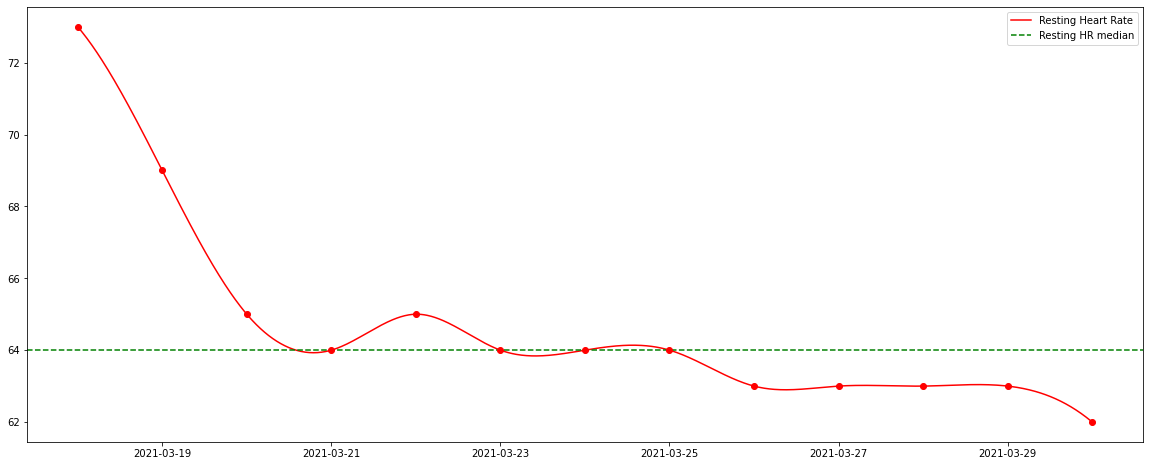

In [110]:
X_ = np.linspace(start.value, end.value, 1000)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
X_ = pd.to_datetime(X_)
plt.plot(X_, Y_,  color = 'r', linestyle = '-', label = 'Resting Heart Rate')
plt.axhline(y = resting_HR_df.resting_HR.median(), color = 'g', linestyle = 'dashed', label = 'Resting HR median')
plt.legend()
plt.plot(resting_HR_df,linestyle='', marker='o', color='r')

<h2>Activity minutes</h2>

In [4]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/tracker/minutesSedentary/date/"+start_date+"/"+end_date+".json", headers=header).json()

minutesSedentary_list = [int(i['value']) for i in response['activities-tracker-minutesSedentary']]

response = requests.get("https://api.fitbit.com/1/user/-/activities/tracker/minutesLightlyActive/date/"+start_date+"/"+end_date+".json", headers=header).json()

minutesLightlyActive_list = [int(i['value']) for i in response['activities-tracker-minutesLightlyActive']]

response = requests.get("https://api.fitbit.com/1/user/-/activities/tracker/minutesFairlyActive/date/"+start_date+"/"+end_date+".json", headers=header).json()

minutesFairlyActive_list = [int(i['value']) for i in response['activities-tracker-minutesFairlyActive']]

response = requests.get("https://api.fitbit.com/1/user/-/activities/tracker/minutesVeryActive/date/"+start_date+"/"+end_date+".json", headers=header).json()

minutesVeryActive_list = [int(i['value']) for i in response['activities-tracker-minutesVeryActive']]

datetime_list = [i['dateTime'] for i in response['activities-tracker-minutesVeryActive']]

<AxesSubplot:>

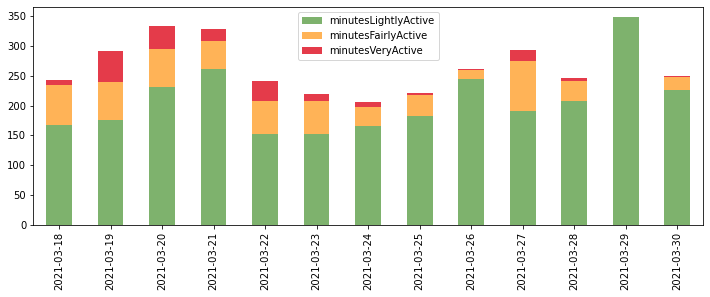

In [14]:
data_activity = {'minutesSedentary':minutesSedentary_list, 'minutesLightlyActive':minutesLightlyActive_list, 'minutesFairlyActive':minutesFairlyActive_list, 'minutesVeryActive':minutesVeryActive_list}

plt.rcParams["figure.figsize"]=12,4

pd.DataFrame(data_activity, index=datetime_list)[['minutesLightlyActive', 'minutesFairlyActive', 'minutesVeryActive']].plot(kind='bar', stacked=True, color=['#7EB26D', '#FFB357', '#E43B4A'])

<h2>Step count</h2>

In [96]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/steps/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-steps']


<AxesSubplot:xlabel='dateTime'>

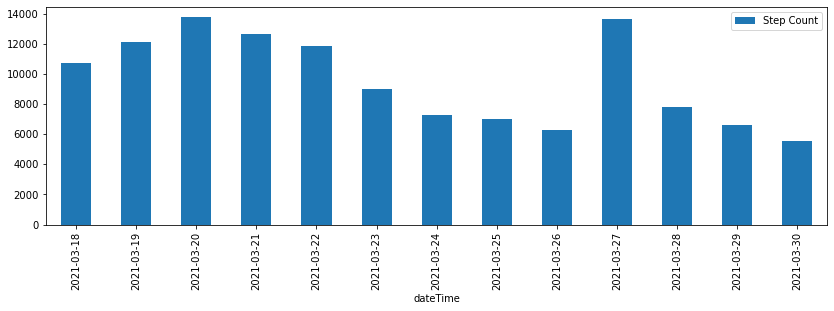

In [97]:
step_df = pd.DataFrame(response)
step_df['dateTime'] = pd.to_datetime(step_df['dateTime'].apply(pd.Timestamp)).dt.date
step_df['Step Count'] = step_df['value'].apply(int)
del step_df['value']
step_df.set_index('dateTime', inplace = True)
step_df.plot(kind = 'bar')

<h2>Distance</h2>

In [98]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/distance/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-distance']


<AxesSubplot:xlabel='dateTime'>

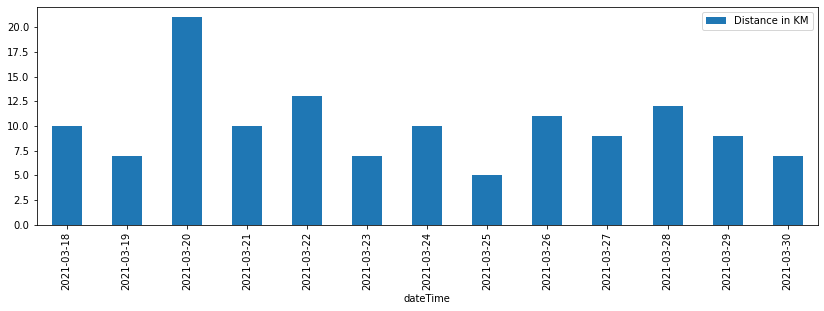

In [101]:
distance_df = pd.DataFrame(response)
distance_df['dateTime'] = pd.to_datetime(distance_df['dateTime'].apply(pd.Timestamp)).dt.date
distance_df['Distance in KM'] = distance_df['value'].apply(float)
del distance_df['value']
distance_df.set_index('dateTime', inplace = True)
distance_df.plot(kind = 'bar')

<h2>Floor count</h2>

In [100]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/floors/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-floors']

<AxesSubplot:xlabel='dateTime'>

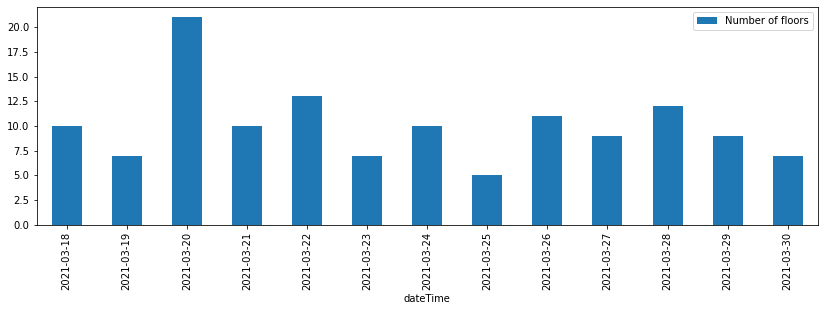

In [104]:
floor_df = pd.DataFrame(response)
floor_df['dateTime'] = pd.to_datetime(floor_df['dateTime'].apply(pd.Timestamp)).dt.date
floor_df['Number of floors'] = floor_df['value'].apply(int)
del floor_df['value']
floor_df.set_index('dateTime', inplace = True)
floor_df.plot(kind = 'bar')

<h2>Calories</h2>

In [106]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/calories/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-calories']

<AxesSubplot:xlabel='dateTime'>

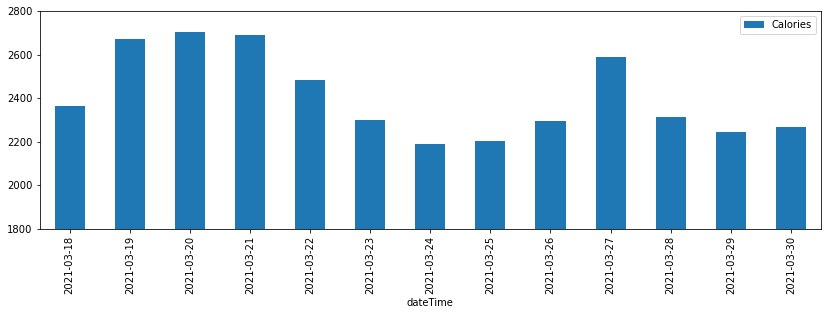

In [114]:
calorie_df = pd.DataFrame(response)
calorie_df['dateTime'] = pd.to_datetime(calorie_df['dateTime'].apply(pd.Timestamp)).dt.date
calorie_df['Calories'] = calorie_df['value'].apply(float)
del calorie_df['value']
calorie_df.set_index('dateTime', inplace = True)
calorie_df.plot(kind = 'bar', ylim = (1800,2800))

<h2>Elevation</h2>

In [126]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/elevation/date/"+start_date+"/"+end_date+"/1min.json", headers=header).json()['activities-elevation']

<AxesSubplot:xlabel='dateTime'>

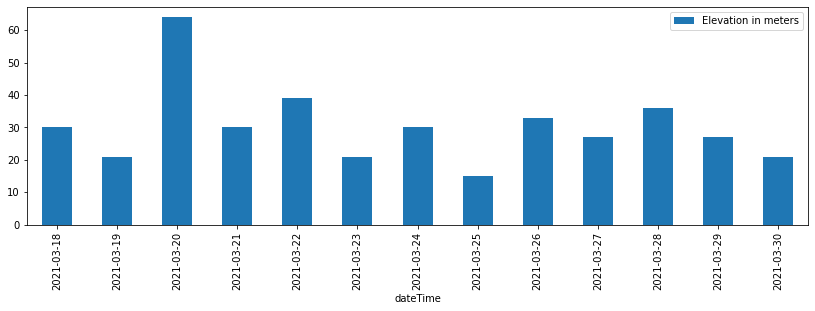

In [129]:
elevation_df = pd.DataFrame(response)
elevation_df['dateTime'] = pd.to_datetime(elevation_df['dateTime'].apply(pd.Timestamp)).dt.date
elevation_df['Elevation in meters'] = elevation_df['value'].apply(float)
del elevation_df['value']
elevation_df.set_index('dateTime', inplace = True)
elevation_df.plot(kind = 'bar')

<h2>Sleeping HR</h2>

In [130]:
sleep_HR_date = "2021-03-31"


In [131]:
splitted_date = sleep_HR_date.split('-')

year = int(splitted_date[0])
month = int(splitted_date[1])
day = int(splitted_date[2])

def parse(date):
    return "{}-{}-{}".format(date[6:], date[:2], date[3:5])

Previous_Date = datetime.datetime(year,month,day) - datetime.timedelta(days=1)
Previous_Date = parse(Previous_Date.strftime('%m/%d/%Y'))

In [132]:
header = {'Authorization': 'Bearer {}'.format(access_token)}

response = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+sleep_HR_date+"/1d/1min/time/00:00/08:00.json", headers=header).json()
response_2 = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+Previous_Date+"/1d/1min/time/22:30/23:59.json", headers=header).json()
prev_response = requests.get("https://api.fitbit.com/1/user/-/activities/heart/date/"+Previous_Date+"/1d.json", headers=header).json()
sleep_response = requests.get("https://api.fitbit.com/1/user/-/sleep/date/"+sleep_HR_date+".json", headers=header).json()

In [133]:
sleep_start_time = sleep_response['sleep'][0]['startTime']
sleep_end_time = sleep_response['sleep'][0]['endTime']

In [134]:
df = pd.DataFrame(response['activities-heart-intraday']['dataset'])
df = df.set_index(pd.to_datetime(sleep_HR_date + ' ' + df['time'].astype(str)))
df2 = pd.DataFrame(response_2['activities-heart-intraday']['dataset'])
df2 = df2.set_index(pd.to_datetime(Previous_Date + ' ' + df2['time'].astype(str)))
del df['time']
del df2['time']
df = df2.append(df)

In [135]:
#range % determination
only_sleep_df = df[sleep_start_time:sleep_end_time]
# % calculation
above_resting = round((len(only_sleep_df[only_sleep_df["value"]>prev_response['activities-heart'][-1]['value']['restingHeartRate']])/len(only_sleep_df)) * 100)
below_resting = 100 - above_resting

#print("Above resting HR :",above_resting,"% \n\n Below resting HR :",below_resting,"%")

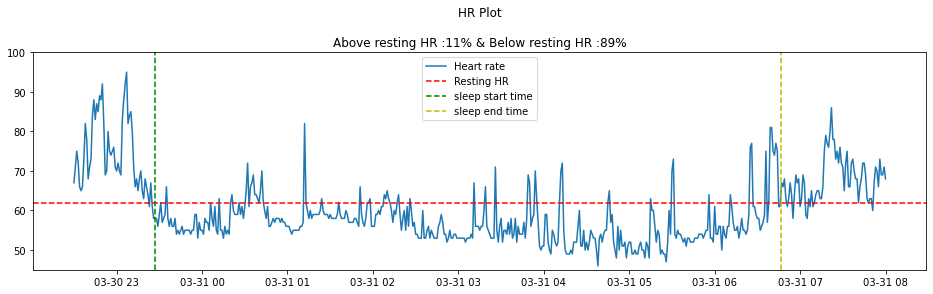

In [137]:
plt.rcParams["figure.figsize"]=16,4
plt.ylim((45,100))
plt.plot(df,label = 'Heart rate')
plt.axhline(y = prev_response['activities-heart'][-1]['value']['restingHeartRate'], color = 'r', linestyle = 'dashed', label = 'Resting HR')
plt.axvline(x = datetime.datetime.strptime(sleep_start_time, '%Y-%m-%dT%H:%M:%S.%f'), color = 'g', linestyle = 'dashed', label = "sleep start time")
plt.axvline(x = datetime.datetime.strptime(sleep_end_time, '%Y-%m-%dT%H:%M:%S.%f'), color = 'y', linestyle = 'dashed', label = 'sleep end time')
plt.title("HR Plot"+"\n\n"+"Above resting HR :"+str(above_resting)+"% & Below resting HR :"+str(below_resting)+"%")
plt.legend()
#plt.grid()
plt.show()